# Network Partitioning with the Kernighan-Lin Algorithm

This notebook demonstrates the Kernighan-Lin algorithm for network partitioning, focusing on the bisection case, where we divide a network into two equal-sized groups while minimizing the connections between them.

## Learning Objectives

- Understand the concept of network partitioning and its applications
- Learn how the Kernighan-Lin algorithm works step by step
- Implement and visualize the algorithm using NetworkX

Let's start by importing the necessary libraries.

In [1]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from collections import defaultdict, deque

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Understanding Network Partitioning

Network partitioning is the task of dividing the nodes of a network into groups of predefined size, such that the number of edges between different groups (the **cut size**) is minimized.

Key applications include:
- Circuit design: minimize wire length between components
- Parallel computing: distribute computational tasks to minimize communication
- Load balancing: distribute workload evenly across resources

### Network Bisection

The specific case we'll focus on is **network bisection** - dividing the network into two equal-sized groups with minimal connections between them.

## 2. Creating Example Networks

Let's create some example networks to demonstrate the Kernighan-Lin algorithm:

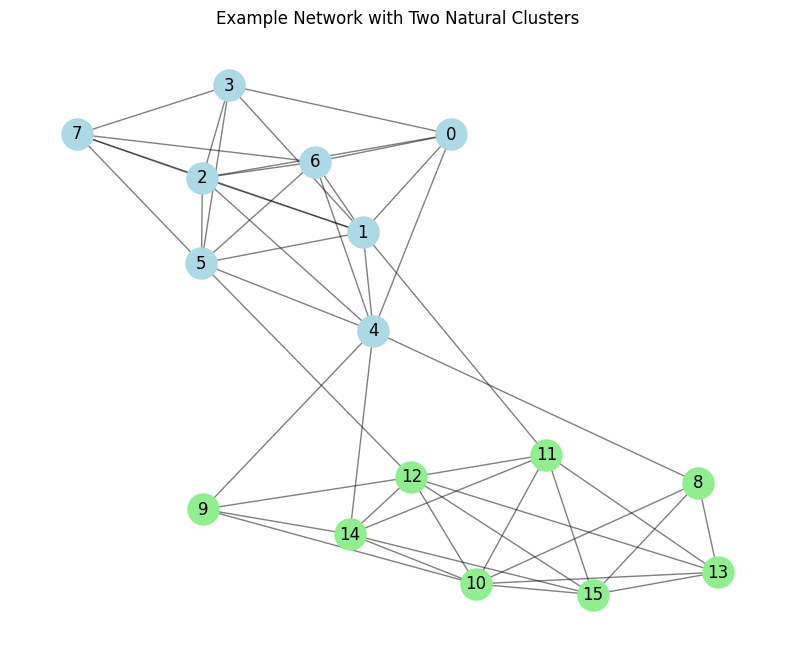

Number of nodes: 16
Number of edges: 48


In [2]:
def create_example_network():
    """Create a simple example network with a clear structure for partitioning"""
    G = nx.Graph()
    
    # Create two dense clusters
    cluster1 = [0, 1, 2, 3, 4, 5, 6, 7]
    cluster2 = [8, 9, 10, 11, 12, 13, 14, 15]
    
    # Add edges within cluster 1 (dense connections)
    for i in range(len(cluster1)):
        for j in range(i+1, len(cluster1)):
            if random.random() < 0.7:  # 70% chance of connection within cluster
                G.add_edge(cluster1[i], cluster1[j])
    
    # Add edges within cluster 2 (dense connections)
    for i in range(len(cluster2)):
        for j in range(i+1, len(cluster2)):
            if random.random() < 0.7:  # 70% chance of connection within cluster
                G.add_edge(cluster2[i], cluster2[j])
    
    # Add a few edges between clusters (sparse connections)
    for i in cluster1:
        for j in cluster2:
            if random.random() < 0.1:  # 10% chance of connection between clusters
                G.add_edge(i, j)
    
    return G

# Create our example network
G = create_example_network()

# Visualize it
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout

# Draw nodes with different colors for the ground truth clusters
nx.draw_networkx_nodes(G, pos, nodelist=range(0, 8), node_color='lightblue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=range(8, 16), node_color='lightgreen', node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)

plt.title("Example Network with Two Natural Clusters")
plt.axis('off')
plt.show()

# Print some basic info about the network
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

## 3. Understanding the Kernighan-Lin Algorithm

The Kernighan-Lin algorithm is a classic heuristic for graph partitioning. Here's how it works:

### Algorithm Overview:

1. **Initialization**: Divide the network into two partitions of equal size (A and B), possibly randomly.
2. **Iterative Improvement**:
   - For each node pair (a,b) where a ∈ A and b ∈ B, calculate the gain if we swap a and b
   - Choose the best pair to swap (highest gain)
   - Mark these nodes as "locked" (cannot be moved again in this pass)
   - Continue swapping until all nodes are locked
   - Find the sequence of swaps with the highest cumulative gain
   - If the maximum gain is positive, apply these swaps and start a new pass
3. **Termination**: Stop when a complete pass produces no improvement

### Key Concept: Gain Calculation

For nodes a ∈ A and b ∈ B, the gain from swapping them is calculated as:

gain(a,b) = D(a) + D(b) - 2*C(a,b)

Where:
- D(a) = external cost of a (sum of edge weights to nodes in B) - internal cost of a (sum of edge weights to nodes in A)
- D(b) = external cost of b (sum of edge weights to nodes in A) - internal cost of b (sum of edge weights to nodes in B)
- C(a,b) = cost of the edge between a and b (0 if no edge exists)

Let's implement a simplified but educational version of the Kernighan-Lin algorithm to see exactly how it works, and then we'll use NetworkX's implementation.

In [3]:
def calculate_cut_size(G, A, B):
    """Calculate the number of edges between partitions A and B"""
    cut_size = 0
    for u in A:
        for v in B:
            if G.has_edge(u, v):
                cut_size += 1
    return cut_size

def calculate_D_values(G, A, B):
    """Calculate D value for each node (external connections - internal connections)"""
    D_values = {}
    
    # For nodes in partition A
    for node in A:
        internal = sum(1 for neighbor in G.neighbors(node) if neighbor in A)
        external = sum(1 for neighbor in G.neighbors(node) if neighbor in B)
        D_values[node] = external - internal
    
    # For nodes in partition B
    for node in B:
        internal = sum(1 for neighbor in G.neighbors(node) if neighbor in B)
        external = sum(1 for neighbor in G.neighbors(node) if neighbor in A)
        D_values[node] = external - internal
    
    return D_values

def calculate_gain(G, a, b, D_values):
    """Calculate the gain from swapping nodes a and b"""
    # Check if nodes are connected
    C_ab = 1 if G.has_edge(a, b) else 0
    
    # Gain formula: D(a) + D(b) - 2*C(a,b)
    gain = D_values[a] + D_values[b] - 2 * C_ab
    
    return gain

def kernighan_lin_step_by_step(G, max_iterations=5):
    """Implement the Kernighan-Lin algorithm with detailed steps"""
    # Get all nodes
    nodes = list(G.nodes())
    
    # Initial random partition
    random.shuffle(nodes)
    midpoint = len(nodes) // 2
    A = set(nodes[:midpoint])
    B = set(nodes[midpoint:])
    
    # Store the history for visualization
    partition_history = [(A.copy(), B.copy())]
    cut_sizes = [calculate_cut_size(G, A, B)]
    
    print(f"Initial partitions:")
    print(f"Partition A: {sorted(list(A))}")
    print(f"Partition B: {sorted(list(B))}")
    print(f"Initial cut size: {cut_sizes[0]}")
    
    print("max iteartions ",max_iterations)
    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration+1} ---")
        
        # Calculate initial D values
        D_values = calculate_D_values(G, A, B)
        
        print("Step 1: Calculate D values for each node")
        for node, d_value in sorted(D_values.items()):
            print(f"  D({node}) = {d_value}")
        
        # Initialize structures for tracking swaps
        unlocked_A = list(A)
        unlocked_B = list(B)
        swaps = []
        gains = []
        cumulative_gain = 0
        
        # Perform node swapping
        while unlocked_A and unlocked_B:
            # Find the best pair to swap
            best_gain = float('-inf')
            best_pair = None
            
            print(f"\nStep 2: Find the best pair to swap")
            for a in unlocked_A:
                for b in unlocked_B:
                    gain = calculate_gain(G, a, b, D_values)
                    print(f"  Gain from swapping {a} and {b}: {gain}")
                    if gain > best_gain:
                        best_gain = gain
                        best_pair = (a, b)
            
            if best_pair is None:
                break
                
            a, b = best_pair
            print(f"  Best pair to swap: {a} and {b} with gain {best_gain}")
            
            # Lock these nodes and record the swap
            unlocked_A.remove(a)
            unlocked_B.remove(b)
            swaps.append((a, b))
            
            # Update D values after this swap
            # In a real implementation, we'd update D values for all remaining unlocked nodes
            # For simplicity, we'll recalculate D values in the next iteration
            
            # Update cumulative gain
            cumulative_gain += best_gain
            gains.append(cumulative_gain)
            
            print(f"  Cumulative gain so far: {cumulative_gain}")
        
        # Find point with maximum cumulative gain
        if not gains:
            print("No more improvements possible")
            break
            
        print(f"\nStep 3: Identify the maximum cumulative gain")
        print(f"  Gains after each swap: {gains}")
        
        max_cumulative_gain = max(gains)
        k = gains.index(max_cumulative_gain)
        
        print(f"  Maximum cumulative gain of {max_cumulative_gain} after {k+1} swaps")
        
        # If max gain is not positive, stop
        if max_cumulative_gain <= 0:
            print("  No improvement possible, stopping iterations")
            break
        
        # Apply the sequence of swaps up to k
        print(f"\nStep 4: Apply the best sequence of swaps")
        for i in range(k + 1):
            a, b = swaps[i]
            print(f"  Swapping {a} and {b}")
            A.remove(a)
            B.remove(b)
            A.add(b)
            B.add(a)
        
        # Calculate new cut size
        new_cut_size = calculate_cut_size(G, A, B)
        partition_history.append((A.copy(), B.copy()))
        cut_sizes.append(new_cut_size)
        
        print(f"\nEnd of iteration {iteration+1}:")
        print(f"  Partition A: {sorted(list(A))}")
        print(f"  Partition B: {sorted(list(B))}")
        print(f"  New cut size: {new_cut_size} (reduced by {cut_sizes[-2] - new_cut_size})")
    
    print(f"\nFinal result after {len(partition_history)-1} iterations:")
    print(f"Initial cut size: {cut_sizes[0]}")
    print(f"Final cut size: {cut_sizes[-1]}")
    print(f"Improvement: {cut_sizes[0] - cut_sizes[-1]} ({100*(cut_sizes[0]-cut_sizes[-1])/cut_sizes[0]:.1f}%)")
    
    return A, B, partition_history, cut_sizes

# Run the step-by-step algorithm
A, B, partition_history, cut_sizes = kernighan_lin_step_by_step(G, max_iterations=100)

Initial partitions:
Partition A: [1, 2, 3, 4, 5, 12, 13, 15]
Partition B: [0, 6, 7, 8, 9, 10, 11, 14]
Initial cut size: 27
max iteartions  100

--- Iteration 1 ---
Step 1: Calculate D values for each node
  D(0) = 3
  D(1) = 0
  D(2) = -1
  D(3) = -1
  D(4) = 2
  D(5) = -3
  D(6) = 2
  D(7) = 3
  D(8) = 2
  D(9) = 0
  D(10) = -1
  D(11) = 2
  D(12) = 1
  D(13) = 1
  D(14) = 0
  D(15) = 2

Step 2: Find the best pair to swap
  Gain from swapping 1 and 0: 1
  Gain from swapping 1 and 6: 0
  Gain from swapping 1 and 7: 1
  Gain from swapping 1 and 8: 2
  Gain from swapping 1 and 9: 0
  Gain from swapping 1 and 10: -1
  Gain from swapping 1 and 11: 0
  Gain from swapping 1 and 14: 0
  Gain from swapping 2 and 0: 0
  Gain from swapping 2 and 6: -1
  Gain from swapping 2 and 7: 0
  Gain from swapping 2 and 8: 1
  Gain from swapping 2 and 9: -1
  Gain from swapping 2 and 10: -2
  Gain from swapping 2 and 11: 1
  Gain from swapping 2 and 14: -1
  Gain from swapping 3 and 0: 0
  Gain from swappi

## 4. Visualizing the Partitioning Progress

Let's visualize how the partitioning improves with each iteration of the algorithm:

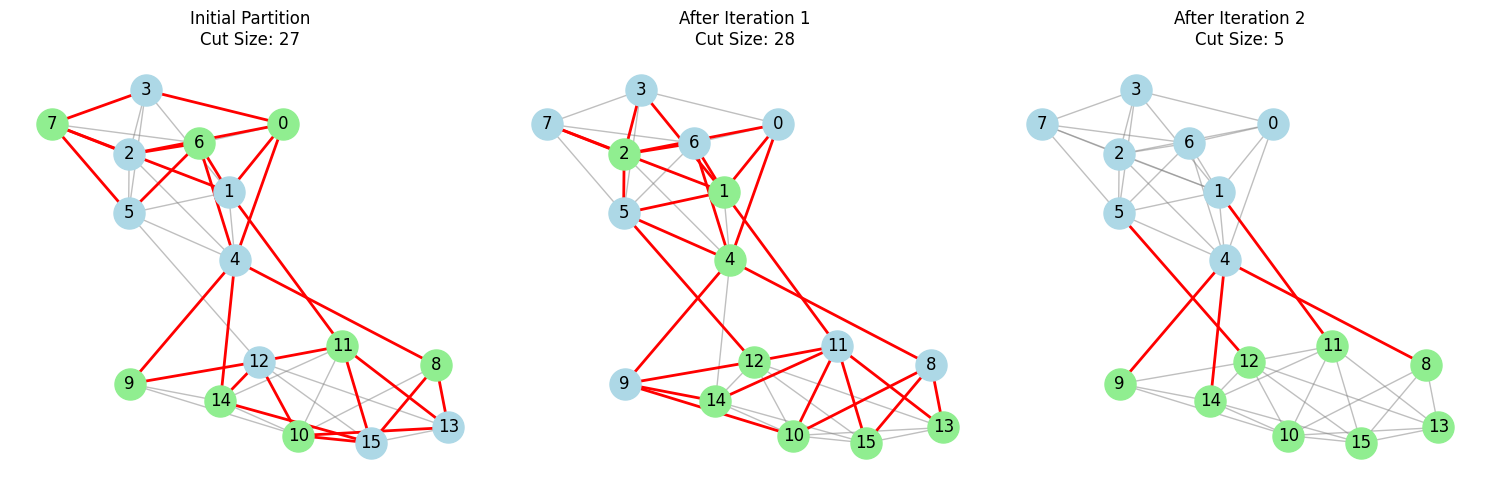

In [4]:
def visualize_partitioning_progress(G, partition_history, cut_sizes):
    """Visualize the partitioning progress over iterations"""
    # Number of partitions to visualize
    n = len(partition_history)
    
    # Create a grid of plots
    fig, axes = plt.subplots(1, n, figsize=(n*5, 5))
    if n == 1:
        axes = [axes]  # Make sure axes is always a list
    
    # Use the same layout for all plots
    pos = nx.spring_layout(G, seed=42)
    
    for i, ((A, B), cut_size) in enumerate(zip(partition_history, cut_sizes)):
        ax = axes[i]
        
        # Draw nodes with different colors for each partition
        nx.draw_networkx_nodes(G, pos, nodelist=list(A), node_color='lightblue', 
                               node_size=500, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=list(B), node_color='lightgreen', 
                               node_size=500, ax=ax)
        
        # Draw edges with different colors
        # Internal edges in gray, cross-partition edges in red
        internal_edges = [(u, v) for u, v in G.edges() if 
                          (u in A and v in A) or (u in B and v in B)]
        cross_edges = [(u, v) for u, v in G.edges() if 
                       (u in A and v in B) or (u in B and v in A)]
        
        nx.draw_networkx_edges(G, pos, edgelist=internal_edges, 
                               alpha=0.5, ax=ax, width=1.0, edge_color='gray')
        nx.draw_networkx_edges(G, pos, edgelist=cross_edges, 
                               alpha=1.0, ax=ax, width=2.0, edge_color='red')
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, ax=ax)
        
        # Set title for each subplot
        if i == 0:
            ax.set_title(f"Initial Partition\nCut Size: {cut_size}")
        else:
            ax.set_title(f"After Iteration {i}\nCut Size: {cut_size}")
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the partitioning progress
visualize_partitioning_progress(G, partition_history, cut_sizes)

## 5. Using NetworkX's Kernighan-Lin Implementation

Now that we understand the algorithm in detail, let's use NetworkX's built-in implementation of the Kernighan-Lin algorithm, which is more optimized and handles edge cases better:

Using NetworkX's Kernighan-Lin implementation...
NetworkX execution time: 0.0003 seconds
Final partitions:
Partition A: [0, 1, 2, 3, 4, 5, 6, 7]
Partition B: [8, 9, 10, 11, 12, 13, 14, 15]
Cut size: 5


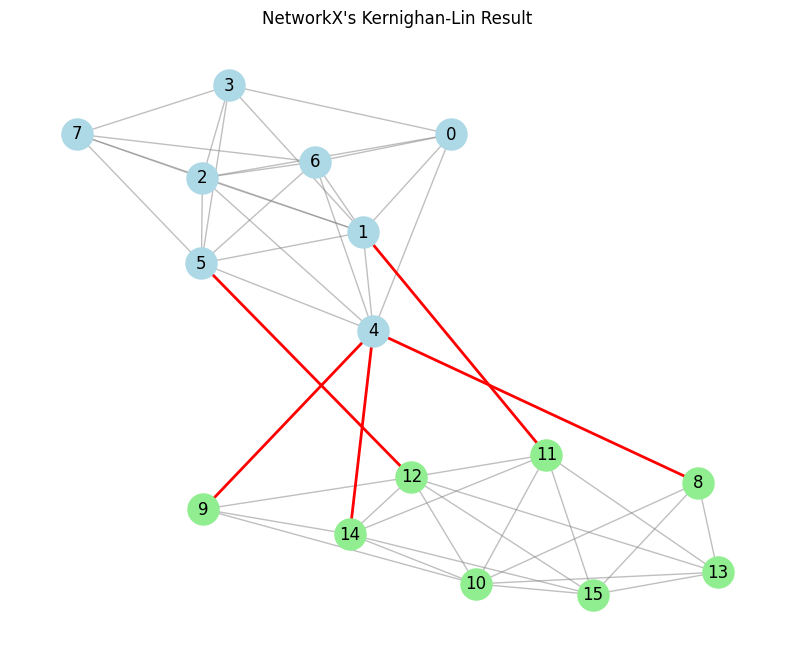

In [5]:
def apply_networkx_kernighan_lin(G):
    """Apply NetworkX's implementation of the Kernighan-Lin algorithm"""
    print("Using NetworkX's Kernighan-Lin implementation...")
    
    # Measure execution time
    start_time = time.time()
    
    # Apply the algorithm
    partition = nx.community.kernighan_lin_bisection(G)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Convert to sets for easier handling
    A = set(partition[0])
    B = set(partition[1])
    
    # Calculate cut size
    cut_size = calculate_cut_size(G, A, B)
    
    print(f"NetworkX execution time: {execution_time:.4f} seconds")
    print(f"Final partitions:")
    print(f"Partition A: {sorted(list(A))}")
    print(f"Partition B: {sorted(list(B))}")
    print(f"Cut size: {cut_size}")
    
    return A, B

# Apply NetworkX's implementation
nx_A, nx_B = apply_networkx_kernighan_lin(G)

# Visualize the result
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout

# Draw nodes with different colors for each partition
nx.draw_networkx_nodes(G, pos, nodelist=list(nx_A), node_color='lightblue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=list(nx_B), node_color='lightgreen', node_size=500)

# Draw edges with different colors
internal_edges = [(u, v) for u, v in G.edges() if 
                  (u in nx_A and v in nx_A) or (u in nx_B and v in nx_B)]
cross_edges = [(u, v) for u, v in G.edges() if 
               (u in nx_A and v in nx_B) or (u in nx_B and v in nx_A)]

nx.draw_networkx_edges(G, pos, edgelist=internal_edges, 
                       alpha=0.5, width=1.0, edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=cross_edges, 
                       alpha=1.0, width=2.0, edge_color='red')

# Draw labels
nx.draw_networkx_labels(G, pos)

plt.title("NetworkX's Kernighan-Lin Result")
plt.axis('off')
plt.show()

## 6. Applying to Real-World Networks

Let's apply the Kernighan-Lin algorithm to some real-world networks to see how it performs:


Applying to Zachary's Karate Club network...
Network info: 34 nodes, 78 edges
Execution time: 0.0002 seconds
Partition sizes: 17, 17
Cut size: 10
Accuracy compared to ground truth: 94.12%


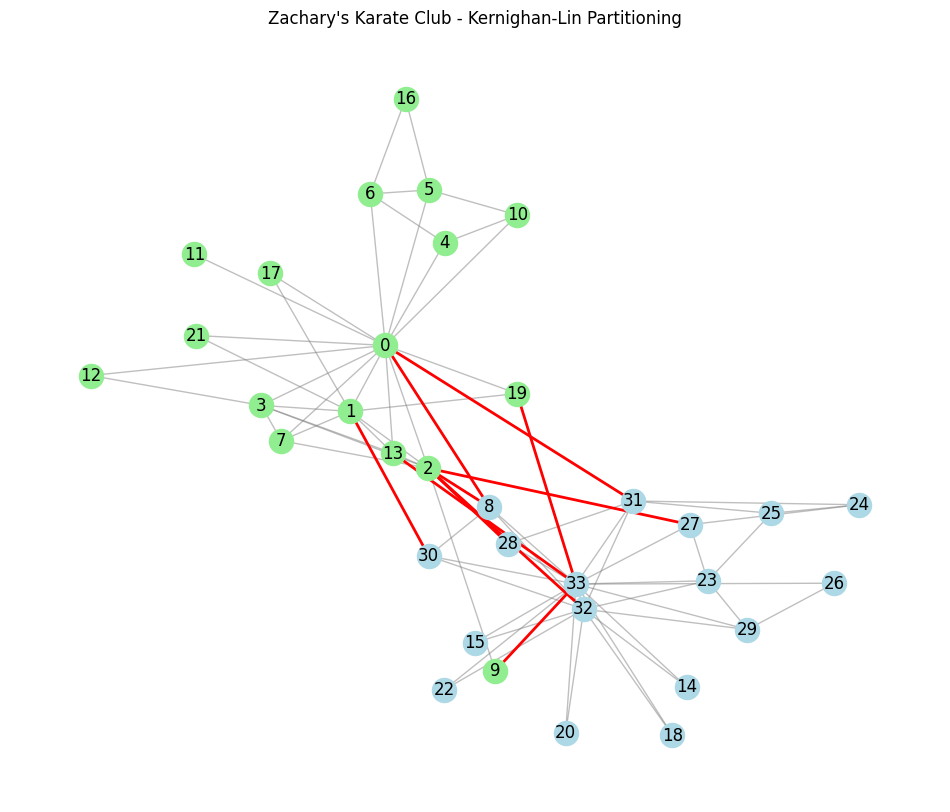

In [6]:
def apply_to_real_network(graph_name):
    """Apply the Kernighan-Lin algorithm to a real-world network"""
    print(f"\nApplying to {graph_name} network...")
    
    if graph_name == "Zachary's Karate Club":
        G = nx.karate_club_graph()
        ground_truth = {node: 0 if node in [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21] else 1
                       for node in G.nodes()}
    elif graph_name == "Political Blogs":
        # Load a subset of the political blogs network for efficiency
        G = nx.Graph()
        # This would normally load from a file, but for simplicity we'll create a small example
        G.add_edges_from([(i, i+1) for i in range(0, 30, 2)])  # Liberal blogs connections
        G.add_edges_from([(i, i+1) for i in range(31, 60, 2)])  # Conservative blogs connections
        G.add_edges_from([(i, i+3) for i in range(0, 28, 4)])  # More liberal connections
        G.add_edges_from([(i, i+3) for i in range(31, 58, 4)])  # More conservative connections
        G.add_edges_from([(0, 31), (10, 41), (20, 51)])  # Cross-group connections
        ground_truth = {node: 0 if node < 31 else 1 for node in G.nodes()}
    else:
        # Default to a random network
        G = nx.random_partition_graph([15, 15], 0.7, 0.1)
        ground_truth = {node: 0 if node < 15 else 1 for node in G.nodes()}
    
    print(f"Network info: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Apply NetworkX's Kernighan-Lin algorithm
    start_time = time.time()
    partition = nx.community.kernighan_lin_bisection(G)
    end_time = time.time()
    
    # Convert to a dictionary for easier comparison
    kl_result = {node: 0 if node in partition[0] else 1 for node in G.nodes()}
    
    # Calculate accuracy compared to ground truth
    correct_count = sum(1 for node in G.nodes() if kl_result[node] == ground_truth[node])
    # Note: Due to label symmetry, we need to also check the inverted result
    inverted_correct = sum(1 for node in G.nodes() if kl_result[node] != ground_truth[node])
    accuracy = max(correct_count, inverted_correct) / G.number_of_nodes()
    
    # Calculate cut size
    cut_size = calculate_cut_size(G, set(partition[0]), set(partition[1]))
    
    print(f"Execution time: {end_time - start_time:.4f} seconds")
    print(f"Partition sizes: {len(partition[0])}, {len(partition[1])}")
    print(f"Cut size: {cut_size}")
    print(f"Accuracy compared to ground truth: {accuracy*100:.2f}%")
    
    # Visualize
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    
    # Draw nodes with different colors for each partition
    nx.draw_networkx_nodes(G, pos, nodelist=partition[0], node_color='lightblue', node_size=300)
    nx.draw_networkx_nodes(G, pos, nodelist=partition[1], node_color='lightgreen', node_size=300)
    
    # Draw edges with different colors
    internal_edges = [(u, v) for u, v in G.edges() if 
                      (u in partition[0] and v in partition[0]) or 
                      (u in partition[1] and v in partition[1])]
    cross_edges = [(u, v) for u, v in G.edges() if 
                   (u in partition[0] and v in partition[1]) or 
                   (u in partition[1] and v in partition[0])]
    
    nx.draw_networkx_edges(G, pos, edgelist=internal_edges, alpha=0.5, width=1.0, edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=cross_edges, alpha=1.0, width=2.0, edge_color='red')
    
    if G.number_of_nodes() <= 40:  # Only show labels for smaller networks
        nx.draw_networkx_labels(G, pos)
    
    plt.title(f"{graph_name} - Kernighan-Lin Partitioning")
    plt.axis('off')
    plt.show()
    
    return G, partition, accuracy

# Apply to Zachary's Karate Club network
karate_G, karate_partition, karate_accuracy = apply_to_real_network("Zachary's Karate Club")

## 7. Practical Applications and Considerations

The Kernighan-Lin algorithm has several practical applications and considerations:

### Applications

1. **VLSI Circuit Design**
   - Partitioning electronic circuits to minimize connections between chips
   - Reducing signal delays and manufacturing costs

2. **Parallel Computing**
   - Distributing computational tasks across processors
   - Minimizing communication overhead between processors

3. **Load Balancing**
   - Distributing workload evenly across servers
   - Reducing data transfer between servers

4. **Image Segmentation**
   - Dividing images into meaningful regions
   - Useful as a preprocessing step in computer vision

### Practical Considerations

1. **Sensitivity to Initial Partition**
   - The algorithm's result heavily depends on the initial partition
   - Often requires multiple runs with different initial partitions

2. **Local Optimality**
   - The algorithm finds locally optimal solutions, not necessarily globally optimal
   - May get stuck in local minima

3. **Computational Complexity**
   - Time complexity: O(n²log(n)) for well-implemented versions
   - Becomes slow for very large networks

4. **Extensions**
   - Can be extended to handle weighted graphs
   - Can be adapted for multi-way partitioning (more than two groups)
   - Often used as a post-processing step after other partitioning methods

## 8. Exercise: Implementing a Multi-way Partitioning

As an exercise, let's implement a multi-way partitioning using repeated applications of the Kernighan-Lin algorithm:

Multi-way partitioning completed in 0.0011 seconds
Number of partitions: 4
Partition sizes: [10, 10, 10, 10]
Total cut size: 33


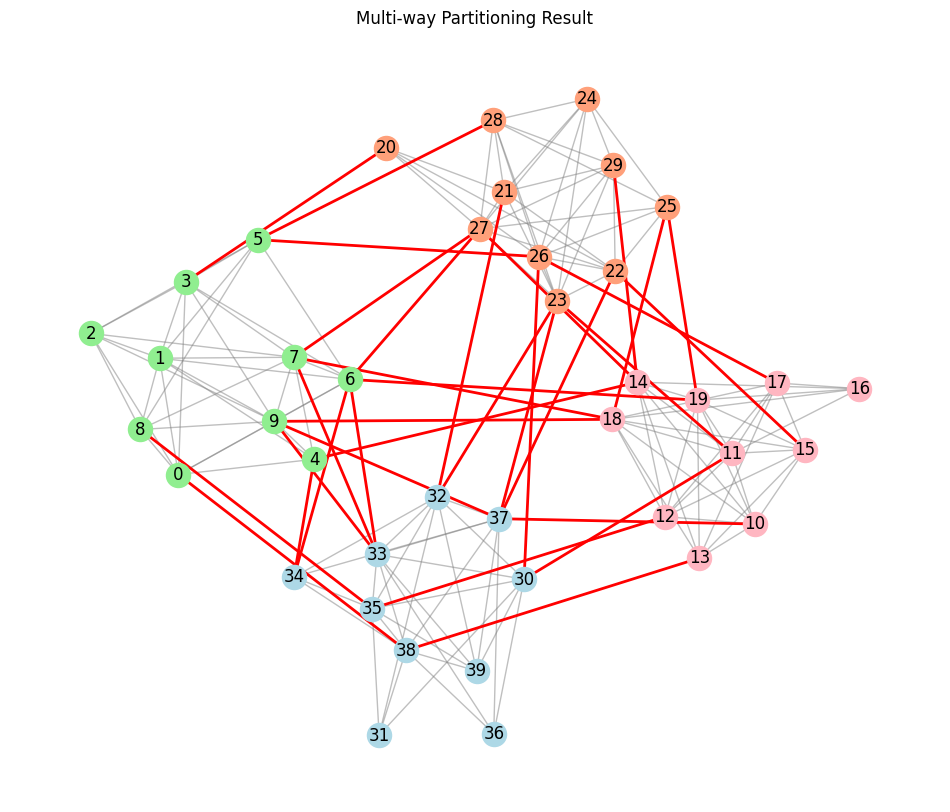

In [7]:
def multi_way_partition(G, k=4):
    """Perform a k-way partitioning using repeated bisection"""
    if k < 2:
        return [list(G.nodes())]
    
    # Start with all nodes in one partition
    partitions = [list(G.nodes())]
    
    # Repeatedly bisect the largest partition until we have k partitions
    while len(partitions) < k:
        # Find the largest partition
        largest_idx = max(range(len(partitions)), key=lambda i: len(partitions[i]))
        largest_partition = partitions[largest_idx]
        
        # If the partition has only one node, we can't bisect it further
        if len(largest_partition) <= 1:
            break
            
        # Create a subgraph from this partition
        subgraph = G.subgraph(largest_partition).copy()
        
        # Apply Kernighan-Lin bisection
        try:
            # If the subgraph is too small for meaningful bisection, use a simpler approach
            if subgraph.number_of_nodes() <= 3:
                mid = len(largest_partition) // 2
                bisection = [largest_partition[:mid], largest_partition[mid:]]
            else:
                bisection = nx.community.kernighan_lin_bisection(subgraph)
                
            # Remove the original partition and add the two new ones
            partitions.pop(largest_idx)
            partitions.extend([list(bisection[0]), list(bisection[1])])
            
        except Exception as e:
            print(f"Error during bisection: {str(e)}")
            break
    
    return partitions

# Create a larger example network
def create_multi_community_network(k=4, nodes_per_community=10, p_in=0.7, p_out=0.05):
    """Create a network with k communities"""
    sizes = [nodes_per_community] * k
    return nx.random_partition_graph(sizes, p_in, p_out, seed=42)

# Create a network with 4 communities
multi_G = create_multi_community_network(k=4)

# Apply multi-way partitioning
start_time = time.time()
partitions = multi_way_partition(multi_G, k=4)
end_time = time.time()

print(f"Multi-way partitioning completed in {end_time - start_time:.4f} seconds")
print(f"Number of partitions: {len(partitions)}")
print(f"Partition sizes: {[len(p) for p in partitions]}")

# Calculate total cut size
total_cut_size = 0
for i, partition_i in enumerate(partitions):
    for j, partition_j in enumerate(partitions):
        if i < j:  # Only count each pair once
            cut_size = calculate_cut_size(multi_G, set(partition_i), set(partition_j))
            total_cut_size += cut_size

print(f"Total cut size: {total_cut_size}")

# Visualize the result
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(multi_G, seed=42)

# Colors for different partitions
colors = ['lightblue', 'lightgreen', 'lightsalmon', 'lightpink', 'lightgray', 'lightyellow']

# Draw nodes with different colors for each partition
for i, partition in enumerate(partitions):
    color = colors[i % len(colors)]
    nx.draw_networkx_nodes(multi_G, pos, nodelist=partition, node_color=color, node_size=300)

# Draw edges
# Identify internal and cross-partition edges
internal_edges = []
cross_edges = []
for u, v in multi_G.edges():
    is_internal = False
    for partition in partitions:
        if u in partition and v in partition:
            internal_edges.append((u, v))
            is_internal = True
            break
    if not is_internal:
        cross_edges.append((u, v))

nx.draw_networkx_edges(multi_G, pos, edgelist=internal_edges, alpha=0.5, width=1.0, edge_color='gray')
nx.draw_networkx_edges(multi_G, pos, edgelist=cross_edges, alpha=1.0, width=2.0, edge_color='red')

# Draw labels for smaller networks
if multi_G.number_of_nodes() <= 60:
    nx.draw_networkx_labels(multi_G, pos)

plt.title("Multi-way Partitioning Result")
plt.axis('off')
plt.show()

## 9. Summary and Conclusions

In this notebook, we've explored the Kernighan-Lin algorithm for network partitioning. Here's a summary of what we've learned:

### Key Concepts

1. **Network Partitioning**: Dividing a network into groups of predefined size to minimize connections between groups.

2. **Kernighan-Lin Algorithm**: An iterative method that improves partitions by swapping pairs of nodes between groups.

3. **Cut Size**: The number of edges crossing between different partitions, which we aim to minimize.

4. **Gain Calculation**: The core of the algorithm, determining which node pairs to swap based on potential cut size reduction.

### Practical Applications

- Circuit design
- Parallel computing
- Load balancing
- Image segmentation

### Limitations and Considerations

- Sensitive to initial partitioning
- Finds locally optimal solutions
- Performance decreases with network size
- Often used in combination with other methods

### Extensions

- Multi-way partitioning
- Weighted networks
- Incorporating additional constraints

The Kernighan-Lin algorithm remains a fundamental tool for network partitioning despite being introduced in the 1970s, demonstrating its robustness and utility across various applications.

## 10. Further Reading

If you want to explore network partitioning further, here are some resources:

1. Kernighan, B. W., & Lin, S. (1970). An efficient heuristic procedure for partitioning graphs. *Bell System Technical Journal*, 49(2), 291-307.

2. Fiduccia, C. M., & Mattheyses, R. M. (1982). A linear-time heuristic for improving network partitions. *19th Design Automation Conference*, 175-181.

3. Karypis, G., & Kumar, V. (1998). A fast and high quality multilevel scheme for partitioning irregular graphs. *SIAM Journal on Scientific Computing*, 20(1), 359-392.

4. Newman, M. E. J. (2006). Modularity and community structure in networks. *Proceedings of the National Academy of Sciences*, 103(23), 8577-8582.

5. Schaeffer, S. E. (2007). Graph clustering. *Computer Science Review*, 1(1), 27-64.

### NetworkX Documentation

- [NetworkX Community API](https://networkx.org/documentation/stable/reference/algorithms/community.html)
- [Kernighan-Lin Bisection](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)